In [22]:
import numpy as np
import math
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops


%matplotlib inline

def load_dataset():
    train_dataset=np.genfromtxt('train.csv', delimiter=',', dtype=np.float32)
    train_set_x_orig=train_dataset[1:32001,1:785]
    train_set_y_orig=train_dataset[1:32001,0]
    
    test_set_x_orig=train_dataset[32001:42001,1:785]
    test_set_y_orig=train_dataset[32001:42001,0]
    
    #train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    #test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

def random_mini_batches(X, Y, mini_batch_size = 256):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    #shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))
    shuffled_Y = Y[:, permutation]
    
    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [32000, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, shape = (n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape = (n_y, None), name = "Y")
    return X, Y


# 随机初始化各个参数
def initializer_parameters():
    W1 = tf.get_variable("W1", [25, 784], initializer = tf.contrib.layers
                         .xavier_initializer())
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers
                         .xavier_initializer())
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10, 12], initializer = tf.contrib.layers
                         .xavier_initializer())
    b3 = tf.get_variable("b3", [10, 1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters

# 前向传播
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    return Z3


# 计算损失值并返回
def compute_cost(Z3, Y):
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits,
                          labels = labels)
                          )
    return cost


def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 256, print_cost = True):
    ops.reset_default_graph()
    (n_x, m) = X_train.shape
    n_y = Y_train.shape[0]
    costs = []
    X, Y = create_placeholders(n_x, n_y)
    parameters = initializer_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):
            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            minibatches = random_mini_batches(X_train,
                                              Y_train,
                                              minibatch_size)
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _, minibatch_cost = sess.run([optimizer, cost],
                                             feed_dict = {X: minibatch_X,
                                                          Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_minibatches

            if print_cost is True and epoch % 100 == 0:
                print("cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost is True and epoch % 5 == 0:
                costs.append(epoch_cost)

        # 绘制损失函数下降过程
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters

In [2]:
# 加载数据集
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()

In [17]:

# 第二维参数设为-1可以让reshape函数自动计算第二维长度
X_train_flatten = X_train_orig.T
X_test_flatten = X_test_orig.T
# 归一化处理
X_train = X_train_flatten / 255
X_test = X_test_flatten / 255
# 把数组转化为矩阵，例如Y_train_orig=[0,1,3,2,4,5]会转换为6*6矩阵，对应元素为1，例如对这个数组而言第3个
# 元素是2，那么对应矩阵的第四列第三行的元素为1
#Y_train = convert_to_one_hot(Y_train_orig, 6)
#Y_test = convert_to_one_hot(Y_test_orig, 6)

Y_train1=tf.one_hot(Y_train_orig, 10, axis=0)
Y_test1=tf.one_hot(Y_test_orig, 10, axis=0)
with tf.Session() as ses:
    [Y_train,Y_test]=ses.run([Y_train1,Y_test1])

cost after epoch 0: 2.114784
cost after epoch 100: 0.172393
cost after epoch 200: 0.115835
cost after epoch 300: 0.084913
cost after epoch 400: 0.063702


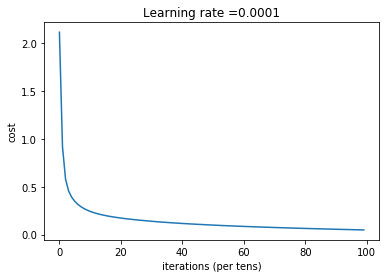

Parameters have been trained!
Train Accuracy: 0.9885
Test Accuracy: 0.9504


In [23]:
parameters = model(X_train, Y_train, X_test, Y_test)